# Example
Start by importing the libraries

In [38]:
import pandas as pd
from pySummarizedExperiment import pySummarizedExperiment

## Using predefined Pandas DataFrames
Using three dataframes, we can create a pySummarizedExperiment. 

In [39]:
data = [[1,2,3,4], [5,6,7,8], [6, 7, 8, 9]]
columns = ["a", "b", "c", "d"]
rownames = ["FT1", "FT2", "FT3"]
data = pd.DataFrame(data, columns = columns, index = rownames)
rowData = pd.DataFrame([1,2,3], index = rownames, columns = ["mz"])
colData = pd.DataFrame([["QC", 1], ["QC", 2], ["BLANK", 3], ["BLANK", 4]],  index=columns, columns = ["Type", "Injection"])
assays = {"first_assay": data, "second_assay": data * 2}
exp = pySummarizedExperiment(assays = assays, colData = colData, rowData = rowData)
exp

class: pySummarizedExperiment
dim: 3 4
metadata(1): Datetime
rownames(3): FT1, FT2, FT3
rowData names(1): mz
colnames(4): a, b, c, d
colData names(2): Type, Injection
assays(2): first_assay, second_assay

## From a long-format DataFrame
We can also create a pySummarizedExperiment using a single long-format dataframe. We need a rowIndex and colIndex to define how to create the rowData and Coldata. Next, the cardinality between columns is checked to define how columns should be assigned. First we create a long dataframe.

In [40]:
from random import randint
from random import seed

seed(42)
df = pd.DataFrame({
    "samples": ["a", "b", "c", "d"] * 5,
    "sample_day": [1, 4, 4, 7] * 5,
    "features": [1, 2, 3, 4, 5] * 4,
    "feature_polarity": ["pos", "neg", "neg", "pos", "pos"] * 4,
    "assay": [randint(0, 1000) for _ in range(20)],
    "assay_other": [_ for _ in range(20)]
})
df.head(5)


,samples,sample_day,features,feature_polarity,assay,assay_other
0,a,1,1,pos,654,0
1,b,4,2,neg,114,1
2,c,4,3,neg,25,2
3,d,7,4,pos,759,3
4,a,1,5,pos,281,4


Next, we create a `pySummarizedExperiment` by setting the dataframe as the `longDf` parameter. Here we use the features column as `rowIndex` parameter and the samples column as `colIndex`. When we print the object, we can see the following:
* The class name
* The dimensions (rows x columns) of the assay. 
* Rownames (row index) of the rowData and Assays
* rowData names, the columns of the rowData
* colnames, the columns of the assay and rowIndex of the colData
* colData names, columns of the colData
* assays, names of the stored assays, first one is used by default 


In [41]:
exp = pySummarizedExperiment(longDf = df, rowIndex = "features", colIndex = "samples")
print(exp)

class: pySummarizedExperiment
dim: 5 4
metadata(1): Datetime
rownames(5): 1, 2, 3, 4, 5
rowData names(1): feature_polarity
colnames(4): a, b, c, d
colData names(1): sample_day
assays(2): assay, assay_other


## Accessing Data
pySummarizedExperiment implements the basic functionality of colData, rowData, and assay functions from R as methods of the object. Here we showcase the methods `.coldata()`, `.rowData()` and `.assay()`. For colData and rowData, it is possible to give one or more column names to receive a subset. For assays, either an assay name or index number of the assay can be given te receive a specific assay. By default, the assay with the first index will be returned.

In [42]:
# colData
exp.colData()

,sample_day
samples,
a,1
b,4
c,4
d,7


In [43]:
# rowData
exp.rowData()

,feature_polarity
features,
1,pos
2,neg
3,neg
4,pos
5,pos


In [44]:
# assay, either use an index or name, both are equal
exp.assay(0) 
exp.assay("assay")

samples,a,b,c,d
features,,,,
1,654,250,692,604
2,432,114,228,758
3,913,32,25,142
4,754,558,30,759
5,281,104,89,95


## Subsetting
The `pySummarizedExperiment` object aims to have similar syntax as Pandas DataFrames. Therefore there are three ways of subsetting data. Using `lists`, `slices` or `masks`. Each of these will be covered below.
### Using lists
We can directly subset the object by providing lists with the indexes and columns. Here we are selecting the 2nd and 3rd row using indexes (1 and 2) and columns 'b' and 'c'. The result is a pySummarizedExperiment with two-by-two dimensions 

In [45]:
exp[[1,2], ["b", "c"]]

class: pySummarizedExperiment
dim: 2 2
metadata(1): Datetime
rownames(2): 2, 3
rowData names(1): feature_polarity
colnames(2): b, c
colData names(1): sample_day
assays(2): assay, assay_other

### Using slices
We can subset the pySummarizedExperiment similar to Pandas syntax. Here we take all rows by supplying an empty slice `:` and take the samples `a` and `b` by supplying a slice of 0:2, which includes columns 0 and 1 (which is equal to columns 'a' and 'b'). Finally, we use the `.assay()` method to receive the assay with the subsetted object.

In [46]:
exp[:, 0:2].assay()

samples,a,b
features,,
1,654,250
2,432,114
3,913,32
4,754,558
5,281,104


### Using masks
A pySummarizedExperiment supports Pandas-style boolean masking for subsetting. Here we are subsetting rows by filtering based on the `feature_polarity` column in the rowData. We select only rows that have `pos` as value. We can see that we only retain rows 1, 4, and 5

In [47]:
exp[exp.rowData("feature_polarity") == "pos", :]

class: pySummarizedExperiment
dim: 3 4
metadata(1): Datetime
rownames(3): 1, 4, 5
rowData names(1): feature_polarity
colnames(4): a, b, c, d
colData names(1): sample_day
assays(2): assay, assay_other

## Plotting
Since `pySummarizedExperiment` is based on Pandas DataFrames, it is easy to inspect data via plots. Some plots can be made directly using plots built in Pandas itself, whereas others can be used using other libraries as `matplotlib` or `seaborn`. Here, we construct a boxplot using the `.boxplot()` method. It accepts the following parameters:
* `assay` Which assay to plot
* `log2`: Transform the given assay with a log2 transformation
* `autoscale`: Transform the assay by scaling and centering
* `transpose`: If true, plot the rows as boxes, plot the columns otherwise (default)

The result can be seen underneath.

<AxesSubplot:>

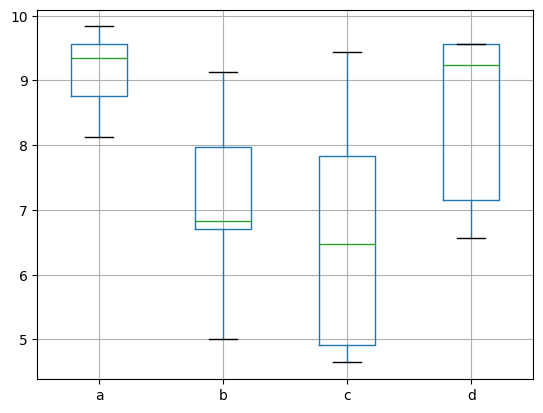

In [48]:
exp.boxplot(assay = 0, log2 = True, autoscale=False, transpose = False)

<AxesSubplot:>

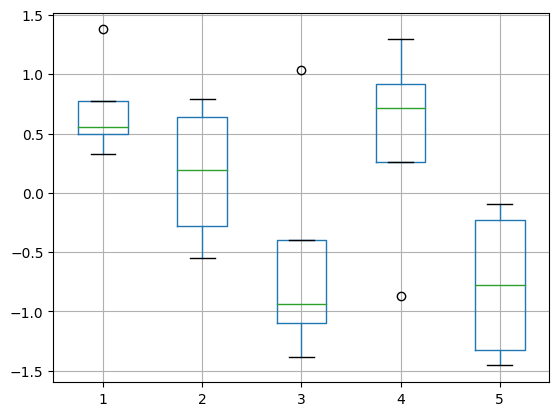

In [49]:
exp.boxplot(assay = 0, log2 = True, autoscale=True, transpose = True)

## Principle Component Analysis (PCA)
One of the most common transformations in -omics fields is a Principle Component Analysis (PCA). Similar to the `.boxplot()` method, this method accepts the `log2`, `autoscale` and `transpose` parameters. However, it also accepts the parameter `components`, which indicates the amount of components to create (defaults to 5). Unlike the `.boxplot()` method, this method returns the PCA DataFrame. Thus it can be plotted by using the `.plot.scatter()` in-built Pandas method.

<AxesSubplot:xlabel='0', ylabel='1'>

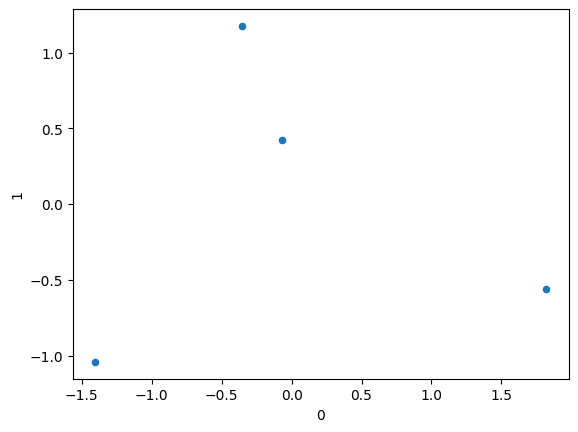

In [50]:
exp.pca(assay = "assay", components = 2, log2 = True, autoscale=True, transpose=True).plot.scatter(x = 0, y = 1)

## Export to long format
To export the data to a single dataframe, we can use the method `toLongDataFrame()`. It will return all data with the exception for metadata. This method is useful for writing data to a single `.csv` or similar data file. 

In [51]:
exp.toLongDataFrame().head(5)

,features,samples,assay,assay_other,feature_polarity,sample_day
0,1,a,654,0,pos,1
1,2,a,432,16,neg,1
2,3,a,913,12,neg,1
3,4,a,754,8,pos,1
4,5,a,281,4,pos,1
